In [7]:
from huggingface_hub import hf_hub_download

params_path = hf_hub_download(repo_id="PaddlePaddle/PP-OCRv5_server_rec", repo_type="model", filename="inference.pdiparams")
print(params_path)

dict_path = hf_hub_download(repo_id="PaddlePaddle/PP-OCRv5_server_rec", repo_type="model", filename="inference.yml")
print(dict_path)

/home/neko/.cache/huggingface/hub/models--PaddlePaddle--PP-OCRv5_server_rec/snapshots/b26c3587fda8da3c8ec0ce357214b4d661ff1558/inference.pdiparams
/home/neko/.cache/huggingface/hub/models--PaddlePaddle--PP-OCRv5_server_rec/snapshots/b26c3587fda8da3c8ec0ce357214b4d661ff1558/inference.yml


In [ ]:
!pixi run pip install --pre paddlepaddle -i https://www.paddlepaddle.org.cn/packages/nightly/cpu/
!mkdir -p .output/PP-OCRv5_server_rec-ONNX
!pixi run paddlex --install paddle2onnx

In [ ]:
!pixi run paddlex --paddle2onnx --paddle_model_dir /home/neko/.cache/huggingface/hub/models--PaddlePaddle--PP-OCRv5_server_rec/snapshots/b26c3587fda8da3c8ec0ce357214b4d661ff1558/ --onnx_model_dir models/PP-OCRv5_server_rec-ONNX/

# Input dir: /home/neko/.cache/huggingface/hub/models--PaddlePaddle--PP-OCRv5_server_rec/snapshots/b26c3587fda8da3c8ec0ce357214b4d661ff1558
# Output dir: .output/PP-OCRv5_server_rec-ONNX
# Paddle2ONNX conversion starting...
# /home/neko/Git/github.com/proj-airi/game-playing-ai-balatro/.pixi/envs/default/lib/python3.12/site-packages/paddle/utils/cpp_extension/extension_utils.py:718: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
#   warnings.warn(warning_message)
# [Paddle2ONNX] Start parsing the Paddle model file...
# [Paddle2ONNX] Use opset_version = 10 for ONNX export.
# [Paddle2ONNX] PaddlePaddle model is exported as ONNX format now.
# 2025-09-22 20:43:04 [INFO]      Try to perform constant folding on the ONNX model with Polygraphy.
# [W] 'colored' module is not installed, will not use colors when logging. To enable colors, please install the 'colored' module: python3 -m pip install colored
# [I] Folding Constants | Pass 1
# [I] Module: 'onnx_graphsurgeon' is required, but not installed. Attempting to install now.
# [I] Running installation command: /home/neko/Git/github.com/proj-airi/game-playing-ai-balatro/.pixi/envs/default/bin/python3.12 -m pip install onnx_graphsurgeon>=0.3.27 --extra-index-url=https://pypi.ngc.nvidia.com
# [I]     Total Nodes | Original:  1111, After Folding:   512 |   599 Nodes Folded
# [I] Folding Constants | Pass 2
# [I]     Total Nodes | Original:   512, After Folding:   512 |     0 Nodes Folded
# 2025-09-22 20:43:10 [INFO]      ONNX model saved in .output/PP-OCRv5_server_rec-ONNX/inference.onnx.
# Paddle2ONNX conversion succeeded
# Copied /home/neko/.cache/huggingface/hub/models--PaddlePaddle--PP-OCRv5_server_rec/snapshots/b26c3587fda8da3c8ec0ce357214b4d661ff1558/inference.yml to models/PP-OCRv5_server_rec-ONNX/inference.yml
# Done

In [ ]:
from onnxruntime import InferenceSession

session = InferenceSession("/home/neko/Git/github.com/proj-airi/game-playing-ai-balatro/models/PP-OCRv5_server_rec-ONNX/inference.onnx", providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])

from PIL import Image

image = Image.open("/home/neko/Git/github.com/proj-airi/game-playing-ai-balatro/test/testdata/image-2.png").convert("RGB")
# transform into numpy array

import numpy as np
image_tensor = np.array(image).astype('float32')

# input info:
# name: x
# tensor: float32[DynamicDimension.0,3,48,DynamicDimension.1]

# according to https://zhuanlan.zhihu.com/p/1913269254393956146 by nihui
# > 输入为BGR图像，高固定是48，宽可变，没有归一化系数
#
# PreProcess:
#   transform_ops:
#   - DecodeImage:
#       channel_first: false
#       img_mode: BGR
#   - MultiLabelEncode:
#       gtc_encode: NRTRLabelEncode
#   - RecResizeImg:
#       image_shape:
#       - 3
#       - 48
#       - 320

# reference code in C++:
# const float rw = object.rrect.size.width;
# const float rh = object.rrect.size.height;

# const int target_height = 48;
# const float target_width = rh * target_height / rw;

# cv::Point2f corners[4];
# object.rrect.points(corners);

# // horizontal text
# // corner points order
# //  0--------1
# //  |        |rw  -> as angle=90
# //  3--------2
# //      rh

# std::vector<cv::Point2f> src_pts(3);
# src_pts[0] = corners[0];
# src_pts[1] = corners[1];
# src_pts[2] = corners[3];

# std::vector<cv::Point2f> dst_pts(3);
# dst_pts[0] = cv::Point2f(0, 0);
# dst_pts[1] = cv::Point2f(target_width, 0);
# dst_pts[2] = cv::Point2f(0, target_height);

# cv::Mat tm = cv::getAffineTransform(src_pts, dst_pts);

# cv::Mat dst;
# cv::warpAffine(bgr, dst, tm, cv::Size(target_width, target_height), cv::INTER_LINEAR, cv::BORDER_REPLICATE);

import cv2
h, w = image_tensor.shape[0:2]
new_w = int(320 * h / 48)
if new_w > 320:
    new_w = 320

image_tensor = cv2.resize(image_tensor, (new_w, 48))
# pad to width 320
padded_image = np.zeros((48, 320, 3), dtype=np.float32)
padded_image[:, :new_w, :] = image_tensor
image_tensor = padded_image
# BGR
image_tensor = image_tensor[:, :, ::-1]
# HWC to CHW
image_tensor = np.transpose(image_tensor, (2, 0, 1))
# add batch dimension
image_tensor = np.expand_dims(image_tensor, axis=0)
# convert to float32
image_tensor = image_tensor.astype('float32')

image_tensor

/home/neko/Git/github.com/proj-airi/game-playing-ai-balatro/.pixi/envs/default/lib/python3.12/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:121: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


array([[[[251., 251., 251., ..., 247., 247., 247.],
         [251., 251., 251., ..., 247., 247., 247.],
         [251., 251., 251., ..., 247., 247., 247.],
         ...,
         [246., 246., 246., ..., 249., 249., 249.],
         [246., 246., 246., ..., 249., 249., 249.],
         [246., 246., 246., ..., 249., 249., 249.]],

        [[243., 243., 243., ..., 245., 245., 245.],
         [243., 243., 243., ..., 245., 245., 245.],
         [242., 242., 242., ..., 245., 245., 245.],
         ...,
         [246., 246., 246., ..., 247., 247., 247.],
         [246., 246., 246., ..., 247., 247., 247.],
         [246., 246., 246., ..., 247., 247., 247.]],

        [[250., 250., 250., ..., 245., 245., 245.],
         [250., 250., 250., ..., 245., 245., 245.],
         [252., 252., 252., ..., 245., 245., 245.],
         ...,
         [246., 246., 246., ..., 247., 247., 247.],
         [246., 246., 246., ..., 247., 247., 247.],
         [246., 246., 246., ..., 247., 247., 247.]]]],
      shape=(1,

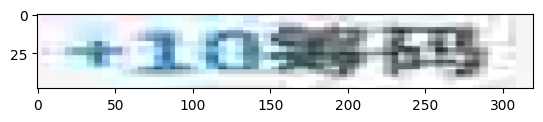

In [39]:
# visualize the preprocessed image
import matplotlib.pyplot as plt
plt.imshow(image_tensor[0].transpose(1, 2, 0)[:, :, ::-1].astype('uint8'))
# save the preprocessed image
plt.savefig("preprocessed_image.png")

In [40]:
# create input
inputs = {session.get_inputs()[0].name: image_tensor}

# run inference
outputs = session.run(None, inputs)

print(outputs)

[array([[[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]]],
      shape=(1, 40, 18385), dtype=float32)]


In [43]:
# reference code in C++:
# // 18385 x len
# for (int i = 0; i < out.h; i++)
# {
#     const float* p = out.row(i);

#     int index = 0;
#     float max_score = -9999.f;
#     for (int j = 0; j < out.w; j++)
#     {
#         float score = *p++;
#         if (score > max_score)
#         {
#             max_score = score;
#             index = j;
#         }
#     }

#     if (index <= 0)
#         continue;

#     Character ch;
#     ch.id = index - 1;
#     ch.prob = max_score;

#     object.text.push_back(ch);
# }

texts = []
for i in range(outputs[0].shape[1]):
    p = outputs[0][0, i, :]
    index = int(np.argmax(p))
    max_score = float(np.max(p))
    if index <= 0:
        continue
    texts.append((index - 1, max_score))

texts

[]

In [ ]:
# all labels in /home/neko/Git/github.com/proj-airi/game-playing-ai-balatro/models/PP-OCRv5_server_rec-ONNX/inference.yml
from yaml import safe_load
with open("/home/neko/Git/github.com/proj-airi/game-playing-ai-balatro/models/PP-OCRv5_server_rec-ONNX/inference.yml", 'r') as f:
    y = safe_load(f)

y["PostProcess"]["character_dict"]
# ['\u3000',
#  '一',
#  '乙',
#  '二',
#  '十',
#  '丁',
#  '厂',
#  '七',
#  '卜',
#  ...
# ]

result_text = ''.join([y["PostProcess"]["character_dict"][id] for id, prob in texts])

result_text

''